### Summary:

The objective of this notebook is to participate in the [LLM - Detect AI Generated Text](https://www.kaggle.com/competitions/llm-detect-ai-generated-text) competition: using a dataset of prompts and texts generated by humans and AI, we have to predict which one is generated by an AI.

### Importing Libraries

In [1]:
# basic libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import time

# for preprocessing
import string
from nltk.tokenize import word_tokenize, sent_tokenize # word, sentence tokenizers
from nltk.stem import WordNetLemmatizer # large word database lemmatization
from nltk.corpus import stopwords # common, not meaningful words
from wordcloud import WordCloud

# for modelling
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
import torch.nn as nn
import transformers
from transformers import AutoModel, BertTokenizerFast, AdamW

# other useful libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

# general commands
%matplotlib inline
warnings.filterwarnings('ignore')
torch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    sentence = [w for w in words if not w in stop_words]
    return " ".join(sentence)

def lemmatization(text):
    word_list = []
    lemmatizer = WordNetLemmatizer()
    sentences = sent_tokenize(text)
    for sentence in sentences:
        words = word_tokenize(sentence)
        for word in words:
            word_list.append(lemmatizer.lemmatize(word))
    return " ".join(word_list)

def cleaning(text):
    delete_dict = {stopword_char: "" for stopword_char in string.punctuation}
    delete_dict[" "] = " "
    table = str.maketrans(delete_dict)
    text_1 = text.translate(table)
    text_array = text_1.split()
    text_2 = " ".join([word for word in text_array])
    return text_2.lower()

### Loading the training input

In [4]:
train_csv = pd.read_csv('./input_data/train_essays.csv')
train_csv.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [5]:
train_csv.shape

(1378, 4)

### EDA on training set

In [6]:
train_viz_df = train_csv.copy()
train_viz_df['generated'].replace({0:'N', 1:'Y'}, inplace=True)

#### AI-Generated (Y) VS. Human-Generated (N)

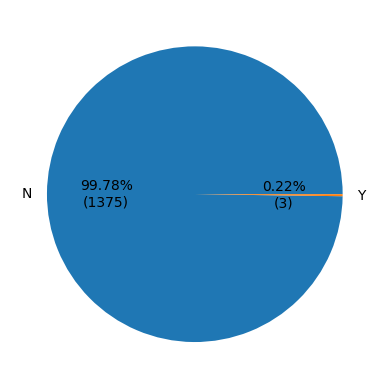

In [7]:
def my_pie_fmt(x):
    return '{:.2f}%\n({:.0f})'.format(x, n_rows*x/100)

vc = train_viz_df['generated'].value_counts(normalize=False, dropna=False)
n_rows = len(train_csv)
plt.pie(vc.replace({0:'N', 1:'Y'}), labels=vc.replace({0:'N', 1:'Y'}).index, autopct=my_pie_fmt)
plt.show()

This is a binary classification problem with high imbalance (few essays are AI-generated).

In [17]:
train_viz_df['text_cleaned'] = train_viz_df['text'].apply(cleaning).apply(remove_stopwords).apply(lemmatization)

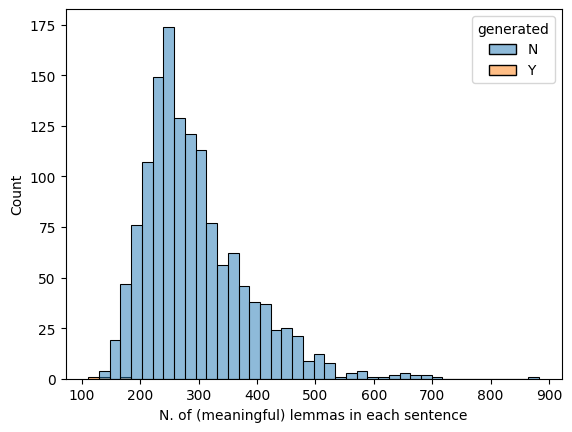

In [18]:
train_viz_df['n_words'] = train_viz_df['text_cleaned'].apply(lambda row: len(row.split()))
sns.histplot(data=train_viz_df, x='n_words', hue='generated')
plt.xlabel('N. of (meaningful) lemmas in each sentence');

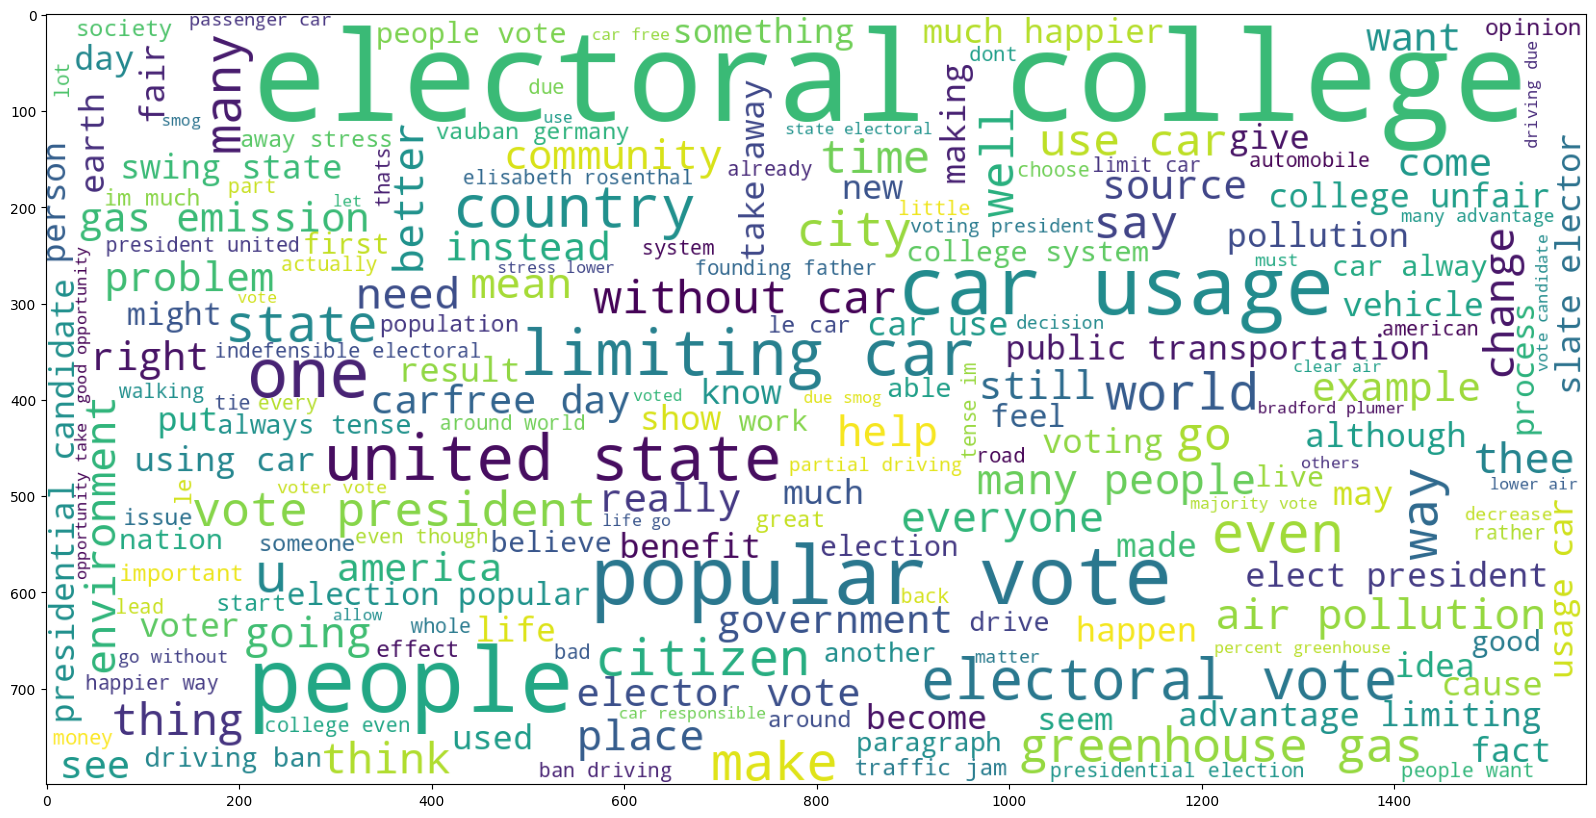

In [19]:
wordcloud = WordCloud(background_color='white', width=1600, height=800
                     ).generate(' '.join(train_viz_df['text_cleaned']))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.show()

#### Loading the prompts CSV files

In [20]:
prompts_csv = pd.read_csv('./input_data/train_prompts.csv')
prompts_csv.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


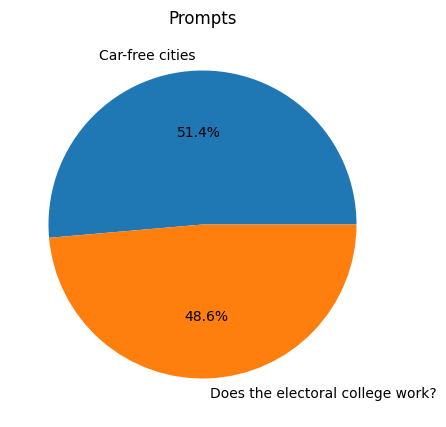

In [21]:
prompt_perc = train_csv.groupby('prompt_id').count()['generated']
plt.figure(figsize=(5,5))
plt.title("Prompts")
plt.pie(prompt_perc, labels=["Car-free cities","Does the electoral college work?"], autopct="%0.1f%%");

The two topics, instead, are equally distributed.

### Adding new data to prevent class imbalance

We can take text generated from the same prompts using other models. These datasets are already available online.

In [22]:
mistral_data_1 = pd.read_csv('./input_data/Mistral7B_CME_v6.csv')
mistral_data_1.shape

(4200, 4)

In [23]:
mistral_data_1.head()

,prompt_id,text,prompt_name,generated
0,6,Introduction:\nVenus is one of the most famou...,Exploring Venus,1
1,6,"Venus, often referred to as Earth’s “sister p...",Exploring Venus,1
2,6,"Venus, the second planet from the sun, is oft...",Exploring Venus,1
3,6,"Venus, also known as the Earth's sister plane...",Exploring Venus,1
4,6,Venus: A Journey into the Future\n\nAs one of...,Exploring Venus,1


In [24]:
mistral_data_1.drop_duplicates(['prompt_id','prompt_name'])[['prompt_id','prompt_name']].sort_values('prompt_id').reset_index(drop=True)

,prompt_id,prompt_name
0,2,Car-free cities
1,4,A Cowboy Who Rode the Waves
2,6,Exploring Venus
3,7,Facial action coding system
4,8,The Face on Mars
5,11,Driverless cars


In [25]:
mistral_data_1 = mistral_data_1[mistral_data_1["prompt_id"] == 2]
mistral_data_1["prompt_id"] = 0 # follow original dataset numbering
mistral_data_1.head()

,prompt_id,text,prompt_name,generated
3500,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3501,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3502,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3503,0,Car-free cities have become increasingly popu...,Car-free cities,1
3504,0,Car-free cities are a growing concept in toda...,Car-free cities,1


In [26]:
mistral_data_2 = pd.read_csv('./input_data/Mistral7B_CME_v7.csv')
mistral_data_2.shape

(4900, 4)

In [27]:
mistral_data_2.head()

,prompt_id,text,prompt_name,generated
0,6,Introduction:\nVenus is one of the most famou...,Exploring Venus,1
1,6,"Venus, often referred to as Earth’s “sister p...",Exploring Venus,1
2,6,"Venus, the second planet from the sun, is oft...",Exploring Venus,1
3,6,"Venus, also known as the Earth's sister plane...",Exploring Venus,1
4,6,Venus: A Journey into the Future\n\nAs one of...,Exploring Venus,1


In [28]:
mistral_data_2.drop_duplicates(['prompt_id','prompt_name'])[['prompt_id','prompt_name']].sort_values('prompt_id').reset_index(drop=True)

,prompt_id,prompt_name
0,2,Car-free cities
1,4,A Cowboy Who Rode the Waves
2,6,Exploring Venus
3,7,Facial action coding system
4,8,The Face on Mars
5,11,Driverless cars
6,12,Does the electoral college work?


In [29]:
mistral_data_2 = mistral_data_2[mistral_data_2["prompt_id"] == 12]
mistral_data_2["prompt_id"] = 1 # follow original dataset numbering
mistral_data_2.head()

,prompt_id,text,prompt_name,generated
4200,1,The electoral college is a system that is use...,Does the electoral college work?,1
4201,1,The electoral college system that is used to ...,Does the electoral college work?,1
4202,1,The electoral college is a system used in the...,Does the electoral college work?,1
4203,1,The electoral college is a system in which ci...,Does the electoral college work?,1
4204,1,The Electoral College is a system used in the...,Does the electoral college work?,1


In [30]:
mistral_data = pd.concat([mistral_data_1, mistral_data_2], axis = 0)
mistral_data.head()

,prompt_id,text,prompt_name,generated
3500,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3501,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3502,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3503,0,Car-free cities have become increasingly popu...,Car-free cities,1
3504,0,Car-free cities are a growing concept in toda...,Car-free cities,1


In [31]:
google_palm_data = pd.read_csv('./input_data/LLM_generated_essay_PaLM.csv').drop(columns = ['id'])
google_palm_data[['prompt_id', 'generated']] = google_palm_data[['prompt_id', 'generated']].astype((int, int))
google_palm_data.head()

,prompt_id,text,generated
0,0,## The Advantages of Limiting Car Usage\n\nIn ...,1
1,0,"The United States is a car-dependent nation, w...",1
2,0,"In recent years, there has been a growing move...",1
3,0,"In recent years, there has been a growing move...",1
4,0,"In the past few decades, the United States has...",1


#### Create unified dataset & visualize input data

In [32]:
input_data = pd.concat(
    [
        train_csv[['text', 'generated']],
        mistral_data[['text', 'generated']].sample(frac=0.5, random_state=42),
        google_palm_data[['text', 'generated']].sample(frac=0.5, random_state=42)]
)
input_data.shape

(2770, 2)

In [33]:
100*input_data['generated'].value_counts(normalize=True)

1    50.361011
0    49.638989
Name: generated, dtype: float64

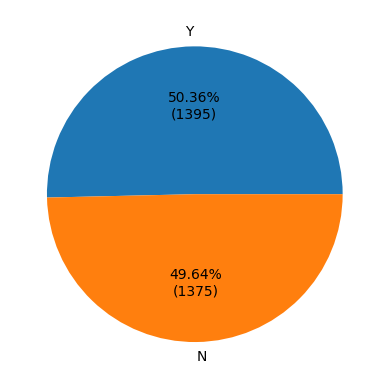

In [34]:
vc = input_data['generated'].replace({0:'N', 1:'Y'}).value_counts(normalize=False, dropna=False)
n_rows = len(input_data)
plt.pie(vc, labels=vc.index, autopct=my_pie_fmt)
plt.show()

In [35]:
input_data['text_cleaned'] = input_data['text'].apply(cleaning).apply(remove_stopwords).apply(lemmatization)

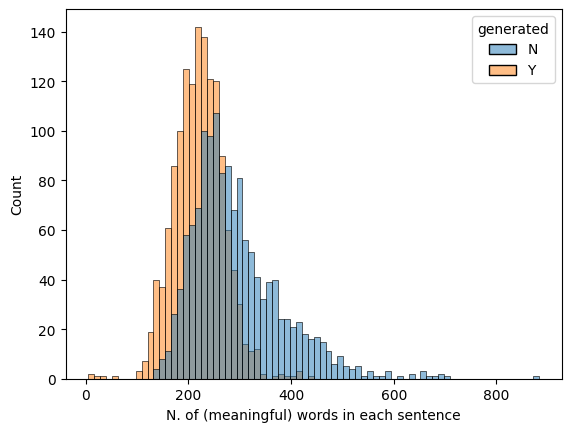

In [36]:
input_data_viz = input_data.copy()
input_data_viz['n_words'] = input_data['text_cleaned'].apply(lambda row: len(row.split()))
sns.histplot(data=input_data_viz.replace({0: 'N', 1: 'Y'}), x='n_words', hue='generated')
plt.xlabel('N. of (meaningful) words in each sentence');

### Modelling
#### Train-validation-test splits (80-10-10)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(input_data['text_cleaned'], input_data['generated'], test_size=0.2, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [80]:
print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

(2216,)
(277,)
(277,)


#### Pretrained BERT model

In [81]:
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

#### Tokenizer Example

In [82]:
text = ['one example','this is another example']
sentence_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

print(sentence_id)

{'input_ids': [[101, 2028, 2742, 102, 0, 0], [101, 2023, 2003, 2178, 2742, 102]], 'attention_mask': [[1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1]]}


#### Padding length cap

To speed up training.

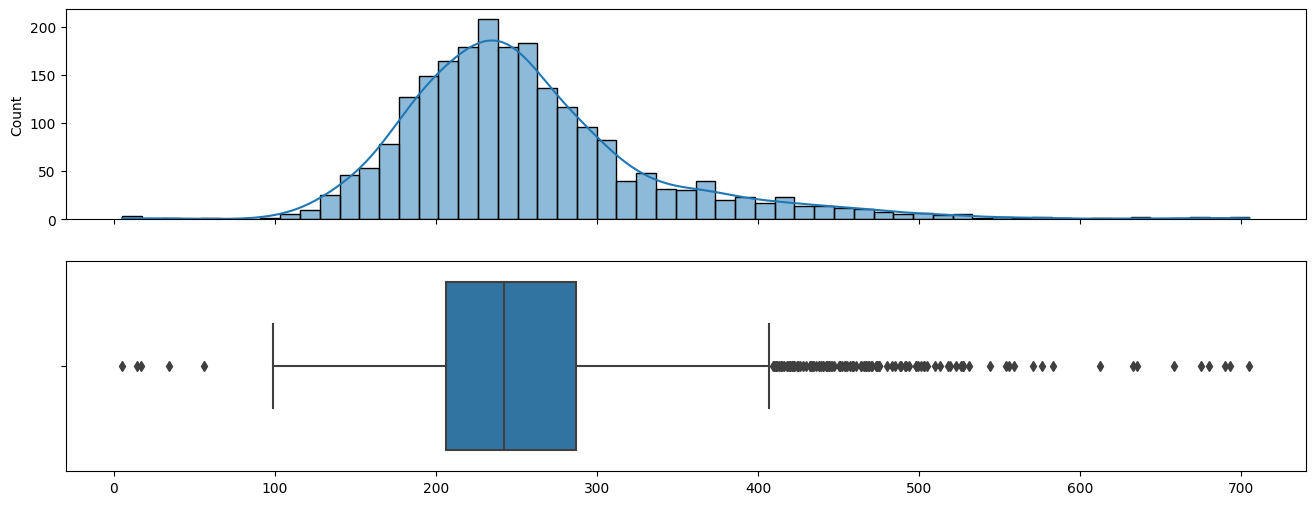

In [83]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(16,6), sharex=True)
sns.histplot([len(i.split()) for i in X_train], kde=True, ax=axs[0])
sns.boxplot(x=[len(i.split()) for i in X_train], ax=axs[1]);

In [84]:
# padding length chosen according to the hist
# note that we're cutting texts that are longer than this - it's a STRONG approximation! (increase accoring to computational power available)
max_seq_len=300

In [85]:
tokens_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length=max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

tokens_validation = tokenizer.batch_encode_plus(
    X_validation.tolist(),
    max_length=max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

tokens_test = tokenizer.batch_encode_plus(
    X_test.tolist(),
    max_length=max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [86]:
# convert input ids and attention masks to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())

validation_seq = torch.tensor(tokens_validation['input_ids'])
validation_mask = torch.tensor(tokens_validation['attention_mask'])
validation_y = torch.tensor(y_validation.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.tolist())

In [87]:
# create data loaders
batch_size = 32 # hyperparam to tune

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_seq, validation_mask, validation_y)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [88]:
# freeze all the parameters of the original model
for param in bert.parameters():
    param.requires_grad = False

In [89]:
# define finetuning model (here the easiest model for computational efficiency)
class BertFineTuning(nn.Module):
    def __init__(self, bert):
        super(BertFineTuning, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 32)  # 768 because the output of the pretrained BERT has dimension 768
        self.fc2 = nn.Linear(32, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        # pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [90]:
# initialize model, optimizer and loss
model = BertFineTuning(bert)
if torch_device == torch.device(type='cuda', index=0):
    model = model.to(torch_device)
optimizer = AdamW(model.parameters(), lr=1e-3) # hyperparam to tune
cross_entropy = nn.NLLLoss()

In [91]:
# it's possible to work directly on the imbalanced dataset specificing the class weights in the loss function
"""
model = BertFineTuning(bert)
if torch_device == torch.device('cuda'):
    model = model.to(torch_device)
optimizer = AdamW(model.parameters(), lr=1e-1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
weights = torch.tensor(class_weights, dtype=torch.float)
if torch_device == torch.device('cuda'):
    weights = weights.to(torch_device)
cross_entropy = nn.NLLLoss(weight=weights)
"""

"\nmodel = BertFineTuning(bert)\nif torch_device == torch.device('cuda'):\n    model = model.to(torch_device)\noptimizer = AdamW(model.parameters(), lr=1e-1)\nclass_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)\nweights = torch.tensor(class_weights, dtype=torch.float)\nif torch_device == torch.device('cuda'):\n    weights = weights.to(torch_device)\ncross_entropy = nn.NLLLoss(weight=weights)\n"

In [92]:
# training and evaluation functions
def train():
    print('  Training...')

    model.train()

    total_loss, total_accuracy = 0, 0
    all_preds = []

    for step, batch in enumerate(train_dataloader):
        if step%10 == 0 and not step == 0:
            print(f'  Batch: {step:.0f} / {len(train_dataloader):.0f}')

        if torch_device == torch.device(type='cuda', index=0):
            batch = [r.to(torch_device) for r in batch]

        sentence_id, mask, labels = batch
        model.zero_grad()                         # clear previously calculated gradients
        preds = model(sentence_id, mask)          # get model predictions for the current batch
        loss = cross_entropy(preds, labels)       # compute the loss between actual and predicted values
        total_loss = total_loss + loss.item()     # add on to the total loss
        loss.backward()                           # backward pass to calculate the gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # clip to 1.0 - prevent the exploding gradient problem
        optimizer.step()                          # update parameters
        if torch_device == torch.device(type='cuda', index=0):
            preds = preds.detach().cpu().numpy()  # model predictions are stored on GPU. So, push it to CPU
        else:
            preds = preds.detach().numpy()

        all_preds.append(preds)

    avg_loss = total_loss / len(train_dataloader) # epoch total loss
    # reshape predictions from shape (no. of batches, size of batch, no. of classes)
    # to shape (number of samples, no. of classes)
    all_preds  = np.concatenate(all_preds, axis=0)

    return avg_loss, all_preds


def evaluate():
    print('  Evaluating...')

    model.eval()                                   # deactivate dropout layers

    total_loss, total_accuracy = 0, 0
    all_preds = []

    for step, batch in enumerate(validation_dataloader):
        if step%10 == 0 and not step == 0:
            print(f'    Batch: {step:.0f} / {len(validation_dataloader):.0f}')

        if torch_device == torch.device(type='cuda', index=0):
            batch = [r.to(torch_device) for r in batch]

        sentence_id, mask, labels = batch
        with torch.no_grad():
            preds = model(sentence_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            if torch_device == torch.device(type='cuda', index=0):
                preds = preds.detach().cpu().numpy() # model predictions are stored on GPU. So, push it to CPU
            else:
                preds = preds.detach().numpy()
            all_preds.append(preds)

    avg_loss = total_loss / len(validation_dataloader)
    all_preds = np.concatenate(all_preds, axis=0)

    return avg_loss, all_preds

In [93]:
# model training
n_epochs = 10 # hyperparam to tune
best_validation_loss = float('inf')

train_losses = []
validation_losses = []

start = time.time()
for epoch in range(n_epochs):

    print(f'Epoch: {epoch+1} / {n_epochs}')

    train_loss, _ = train()
    validation_loss, _ = evaluate()

    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    train_losses.append(train_loss)
    validation_losses.append(validation_loss)

    print(f"\tTraining Loss: {train_loss:.3f}")
    print(f"\tValidation Loss: {validation_loss:3f}")

end = time.time()
print(f"Training Time: {end-start} s.")

Epoch: 1 / 10
  Training...
  Batch: 10 / 70
  Batch: 20 / 70
  Batch: 30 / 70
  Batch: 40 / 70
  Batch: 50 / 70
  Batch: 60 / 70
  Evaluating...
	Training Loss: 0.559
	Validation Loss: 0.427294
Epoch: 2 / 10
  Training...
  Batch: 10 / 70
  Batch: 20 / 70
  Batch: 30 / 70
  Batch: 40 / 70
  Batch: 50 / 70
  Batch: 60 / 70
  Evaluating...
	Training Loss: 0.406
	Validation Loss: 0.381129
Epoch: 3 / 10
  Training...
  Batch: 10 / 70
  Batch: 20 / 70
  Batch: 30 / 70
  Batch: 40 / 70
  Batch: 50 / 70
  Batch: 60 / 70
  Evaluating...
	Training Loss: 0.319
	Validation Loss: 0.243397
Epoch: 4 / 10
  Training...
  Batch: 10 / 70
  Batch: 20 / 70
  Batch: 30 / 70
  Batch: 40 / 70
  Batch: 50 / 70
  Batch: 60 / 70
  Evaluating...
	Training Loss: 0.259
	Validation Loss: 0.165540
Epoch: 5 / 10
  Training...
  Batch: 10 / 70
  Batch: 20 / 70
  Batch: 30 / 70
  Batch: 40 / 70
  Batch: 50 / 70
  Batch: 60 / 70
  Evaluating...
	Training Loss: 0.229
	Validation Loss: 0.108664
Epoch: 6 / 10
  Training.

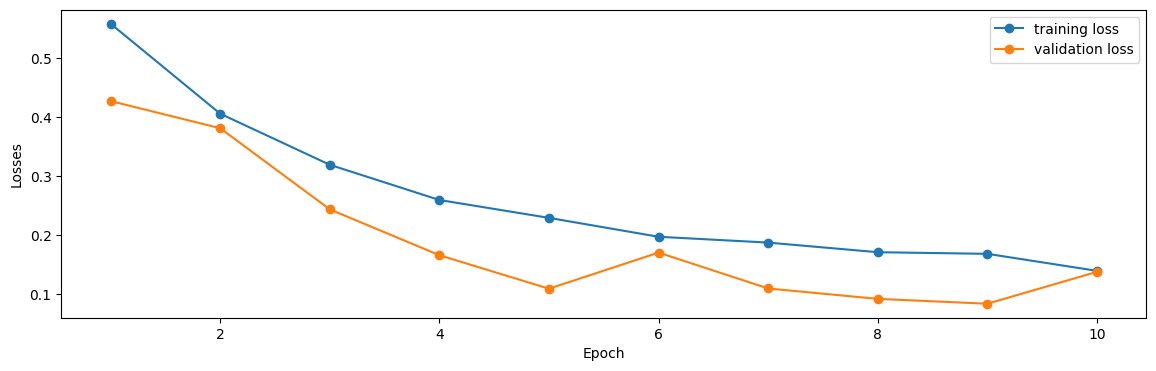

In [94]:
plt.figure(figsize=(14,4))
plt.plot(list(i+1 for i in range(n_epochs)), train_losses, '-o', label='training loss')
plt.plot(list(i+1 for i in range(n_epochs)), validation_losses, '-o', label='validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.show()

### Predictions

In [95]:
with torch.no_grad():
  preds = model(test_seq.to(torch_device), test_mask.to(torch_device))
  preds = preds.detach().cpu().numpy()

# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93       142
           1       0.88      1.00      0.93       135

    accuracy                           0.93       277
   macro avg       0.94      0.93      0.93       277
weighted avg       0.94      0.93      0.93       277



As we can see, this simple model is capable to predict quite well whether a text has been generated by an AI or not. Finetuning the hyperparameters of this model would surely improve the results even more.